### Text Mining - Mini Project 3

#### Team Members:

Rahul Krishna Gunneri        - 2210264 <br>
Vom Siri Krrishna Jorige     - 2211625 <br>
Harshavardhan Lingammagari   - 2251826

### Download essential libraries

In [117]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
#!pip install --upgrade scipy
#!pip install --upgrade numpy
# !pip install gensim
# !pip install spacy
# !pip install pyLDAvis

### Importing necessary modules

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import re
import string

# Preprocessing libraries
import os
import nltk
import time
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk import ngrams
from wordcloud import WordCloud

# Gensim library
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
#!pip install spacy
import spacy
from nltk.corpus import stopwords

# Libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import chardet
from pprint import pprint

import warnings
warnings.filterwarnings('ignore')

In [119]:
'''
The below function reads a given .txt file line by line.
If the sentence contains 'Document NYTF ...', it is an indication that the article has ended.
We have made use of the .find() method to check for the occurrence of 'Document NYTF'
All the articles are appended to the top-level list.

The return value looks like:
article_list = [article1, article2, .......... article n]

'''

"\nThe below function reads a given .txt file line by line.\nIf the sentence contains 'Document NYTF ...', it is an indication that the article has ended.\nWe have made use of the .find() method to check for the occurrence of 'Document NYTF'\nAll the articles are appended to the top-level list.\n\nThe return value looks like:\narticle_list = [article1, article2, .......... article n]\n\n"

In [120]:
import os

# Function to detect encoding using chardet
def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        rawdata = f.read()
    result = chardet.detect(rawdata)
    return result['encoding']


# Crawls through the directory and reads all the files present inside it.
def article_separator(dir_path):
    articles_list = []
    count = 0
    for root, folders, files in os.walk(dir_path):
        for file in files:
            file_path = os.path.join(root, file)
            article = ''
            
            # Detect the encoding of the file
            file_encoding = detect_encoding(file_path)
            
            with open(file_path, 'r', encoding=file_encoding, errors='replace') as f:
                for sentence in f.readlines():
                    if all(doc not in sentence for doc in ('Document INHT','Document NYTF', 'Document WSJ', 'Document J000', 'Document AWSJ')):
                        article += sentence
                    else:
                        articles_list.append(article)
                        article = ''     
    return data_cleaning(articles_list)

In [121]:
# Path to the raw text files -- Please update this while running on your machine

articles_list = article_separator('C:\\Users\\LENOVO\\OneDrive - University Of Houston (1)\\Desktop\\UH\\04_Fall_2023\\CIS6397- Text_Mining\\Mini_Project_3\\Articles')

In [122]:
print('Total count of articles: ', len(articles_list))

Total count of articles:  1630


In [123]:
print('Sample article view: \n', articles_list[0][:200])

Sample article view: 
 World; Europe
In Turkey, U.S. Hand Is Seen in Nearly Every Crisis
By TIM ARANGO
1,447 words
4 January 2017
09:45
NYTimes.com Feed
NYTFEED
English
Copyright 2017. The New York Times Company. All Rights


In [174]:
import re
import string

def article_cleanser(article):
    # Lowercase text
    article = article.lower()
    # Remove HTML tags
    html_tags = re.compile('<.*?>')
    article = re.sub(html_tags, '', article)
    # Remove text within [] and ()
    article = re.sub('\[.*?\]', '', article)
    article = re.sub('\(.*?\)', '', article)
    # Remove Punctuation marks
    article = re.sub('[%s]' % re.escape(string.punctuation), '', article)
    article = re.sub('\w*\d\w*', '', article)
    # Remove extra characters such as single quotes and double quotes
    article = re.sub('[‘’“”…—]', '', article)
    # Remove escape characters like next line, tab space, etc
    article = re.sub('[\n\t\r\d]', ' ', article)
    article = re.sub(r'[^a-zA-Z\s]', '', article)
    article = re.sub(r'\s+', ' ', article).strip()
    
    '''
    Every article consists of metadata that starts from the first line and ends with 'all rights reserved'
    Therefore, we are eliminating all the text that forms the metadata.
    '''   
    # Removing the metadata
    article = re.sub('^(.*?)(all rights reserved)', '', article)
    
    # Removes the left and right spaces of the text.
    article = article.lstrip().rstrip()
    return article

In [175]:
# This will call the article_cleanser function above
def preprocessor(article_list):
    cleaned_articles = []
    for article in articles_list:
        cleaned_article = article_cleanser(article)
        cleaned_articles.append(cleaned_article)
    return cleaned_articles

In [176]:
# Returns the list of all the preprocessed articles

cleaned_articles = preprocessor(articles_list)

In [177]:
# Sample view of the article 1 after cleaning

cleaned_articles[0][:100]

'istanbul urkish officials accused the united states of abetting a failed coup last summer when the r'

In [178]:
# Converts the input text string into tokens
def word_tokenizer(corpus):
    corpus_tokens = word_tokenize(corpus)
    return corpus_tokens

In [179]:
# Writes the stop words to the file 'Stopwords.txt'
def write_to_file(stopwords):
    with open('Stopwords.txt', 'w') as file:
        for word in stopwords:
            file.write(word + '\n')

In [180]:
# Fetches the stop words from 'English' lang in NLTK library
def get_stopwords_english():
    stop_words = set(stopwords.words('english'))
    print('Count of stop words: ', len(stop_words))
    return stop_words

In [181]:
# Fetches the multilingual stop words from NLTK library
def get_stopwords():
    # fileids() returns all the languages present in the NLTK library.
    languages = stopwords.fileids()
    global_stop_words = []
    try:
        temp = []
        for lang in languages:
            lang_stop_words = set(stopwords.words(lang))
            temp.append(lang_stop_words)
    except:
        print('Encontered an error with : ', lang)
    
    for sublist in temp:
        for word in sublist:
            global_stop_words.append(word)
    
#   write_to_file(global_stop_words)
    print('Count of stop words: ', len(global_stop_words))
    return global_stop_words

In [182]:
%%time

'''
Tokenization:

tokens_list: List of lists of articles. (Top level list)
article_tokens: tokens of individual articles.

'''
tokens_list = []
for article in cleaned_articles:
    article_tokens = word_tokenizer(article)
    tokens_list.append(article_tokens)

Wall time: 11.6 s


In [183]:
%%time

'''
Stop word removal
'''

# Fetches the stop words from the function
stop_words = get_stopwords()
def remove_stopwords(tokens_list):
    return [[token for token in article_tokens if token not in stop_words] for article_tokens in tokens_list]

Count of stop words:  10204
Wall time: 44.2 ms


In [184]:
# Processed tokens after removing all the stop words
all_tokens_without_stop = remove_stopwords(tokens_list)

In [185]:
# Sample list of all the tokens after stop word removal
all_tokens_without_stop[0][:20]

['istanbul',
 'urkish',
 'officials',
 'accused',
 'united',
 'states',
 'abetting',
 'failed',
 'coup',
 'summer',
 'russian',
 'ambassador',
 'turkey',
 'assassinated',
 'month',
 'turkish',
 'press',
 'united',
 'states',
 'attack']

In [186]:
%%time

# Unwind all the tokens into one list for analyzing data.
# unified_tokens: All tokens in one list

unified_tokens = []
for sublist in all_tokens_without_stop:
    for token in sublist:
        unified_tokens.append(token)

Wall time: 439 ms


In [187]:
print('Length of all the tokens in the corpus: ', len(unified_tokens))

Length of all the tokens in the corpus:  859631


In [188]:
# Returns the list of most frequent words as per the requirement
def freq_Distribution(processed_tokens, top_word_count):
    top_words = FreqDist(processed_tokens).most_common(top_word_count)
    return top_words

In [189]:
# Function to generate the bar graphs or count plot of frequent words

def generate_bar_graph(freq_dict):
    plt.figure(figsize=(6, 4))
    plt.title("Top 30 unigrams in corpus", fontsize=10)
    sns.barplot(y = list(freq_dict.values()), x = list(freq_dict.keys()))
    plt.xlabel('Most Repeating Words')
    plt.xticks(rotation = 90)
    plt.ylabel('Average Frequency')
    plt.grid(visible = False)
    plt.show()

In [190]:
# Function to generate the word cloud for clusters

def generate_word_cloud(freq_dict):
    try:
        wordcloud = WordCloud(min_word_length =3, background_color='white', max_words = 100)
        wordcloud.generate_from_frequencies(freq_dict)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title('Word Cloud of most common unigrams', size = 10)
        plt.axis('off')
        plt.show()
    except:
        print('An exception occurred while plotting the word cloud.')

In [191]:
def n_grams(unified_tokens, n, words_req):
    if n == 1:
        grams = unified_tokens
    else:
        grams = ngrams(unified_tokens, n)
    print('Top {} {}-grams: \n'.format(words_req, n))
    top_n_grams = FreqDist(grams).most_common(words_req)
    return top_n_grams

In [192]:
# Top 30 unigrams in the corpus
top_30_unigrams = n_grams(unified_tokens, 1, 30)
print(top_30_unigrams)

Top 30 1-grams: 

[('mr', 9814), ('state', 6745), ('trump', 6591), ('islamic', 6165), ('president', 3982), ('syria', 3741), ('states', 3509), ('american', 3464), ('united', 3416), ('military', 3225), ('forces', 2734), ('iraq', 2672), ('government', 2497), ('officials', 2449), ('isis', 2401), ('attack', 2164), ('syrian', 2148), ('group', 2101), ('city', 2097), ('security', 2068), ('years', 1966), ('time', 1887), ('country', 1867), ('iraqi', 1856), ('administration', 1760), ('times', 1723), ('killed', 1673), ('news', 1642), ('house', 1588), ('russia', 1545)]


In [193]:
# Convert above list of tuples into frequency dictionary
unigram_dict_30 = dict(top_30_unigrams)

In [194]:
unigram_dict_30

{'mr': 9814,
 'state': 6745,
 'trump': 6591,
 'islamic': 6165,
 'president': 3982,
 'syria': 3741,
 'states': 3509,
 'american': 3464,
 'united': 3416,
 'military': 3225,
 'forces': 2734,
 'iraq': 2672,
 'government': 2497,
 'officials': 2449,
 'isis': 2401,
 'attack': 2164,
 'syrian': 2148,
 'group': 2101,
 'city': 2097,
 'security': 2068,
 'years': 1966,
 'time': 1887,
 'country': 1867,
 'iraqi': 1856,
 'administration': 1760,
 'times': 1723,
 'killed': 1673,
 'news': 1642,
 'house': 1588,
 'russia': 1545}

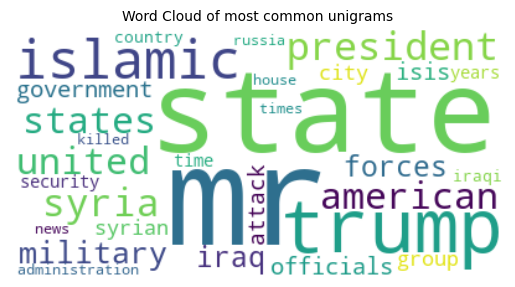

In [195]:
# Word cloud generator for unigrams
generate_word_cloud(unigram_dict_30)

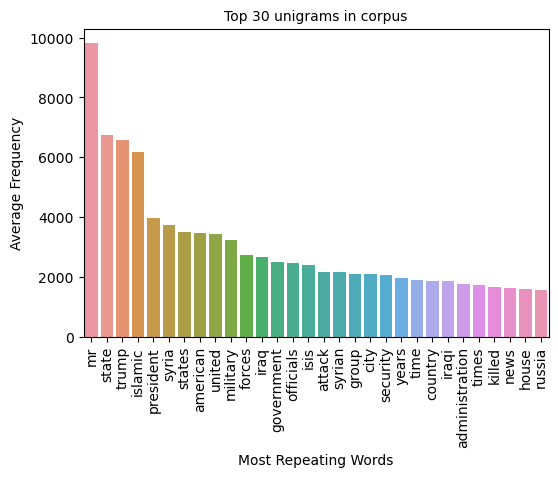

In [196]:
# Bar graph generator for unigrams

generate_bar_graph(unigram_dict_30)

In [197]:
# Top 30 bigrams in the entire corpus
top_30_bi_grams = n_grams(unified_tokens, 2, 30)
print(top_30_bi_grams)

Top 30 2-grams: 

[(('islamic', 'state'), 5278), (('united', 'states'), 2848), (('mr', 'trump'), 2307), (('white', 'house'), 1007), (('york', 'times'), 975), (('president', 'trump'), 889), (('trump', 'administration'), 633), (('middle', 'east'), 592), (('donald', 'trump'), 566), (('national', 'security'), 496), (('saudi', 'arabia'), 466), (('mr', 'trumps'), 425), (('mr', 'assad'), 419), (('mr', 'obama'), 416), (('prime', 'minister'), 390), (('state', 'fighters'), 383), (('iraq', 'syria'), 381), (('islamic', 'states'), 375), (('obama', 'administration'), 361), (('chemical', 'weapons'), 357), (('north', 'korea'), 333), (('iraqi', 'forces'), 328), (('executive', 'order'), 316), (('secretary', 'state'), 304), (('united', 'nations'), 291), (('facebook', 'twitter'), 286), (('social', 'media'), 273), (('barack', 'obama'), 272), (('mr', 'mattis'), 271), (('state', 'department'), 270)]


In [198]:
# Convert above list of tuples into frequency dictionary
bigrams_30_dict = dict(top_30_bi_grams)

In [199]:
print(list(bigrams_30_dict.keys()))

[('islamic', 'state'), ('united', 'states'), ('mr', 'trump'), ('white', 'house'), ('york', 'times'), ('president', 'trump'), ('trump', 'administration'), ('middle', 'east'), ('donald', 'trump'), ('national', 'security'), ('saudi', 'arabia'), ('mr', 'trumps'), ('mr', 'assad'), ('mr', 'obama'), ('prime', 'minister'), ('state', 'fighters'), ('iraq', 'syria'), ('islamic', 'states'), ('obama', 'administration'), ('chemical', 'weapons'), ('north', 'korea'), ('iraqi', 'forces'), ('executive', 'order'), ('secretary', 'state'), ('united', 'nations'), ('facebook', 'twitter'), ('social', 'media'), ('barack', 'obama'), ('mr', 'mattis'), ('state', 'department')]


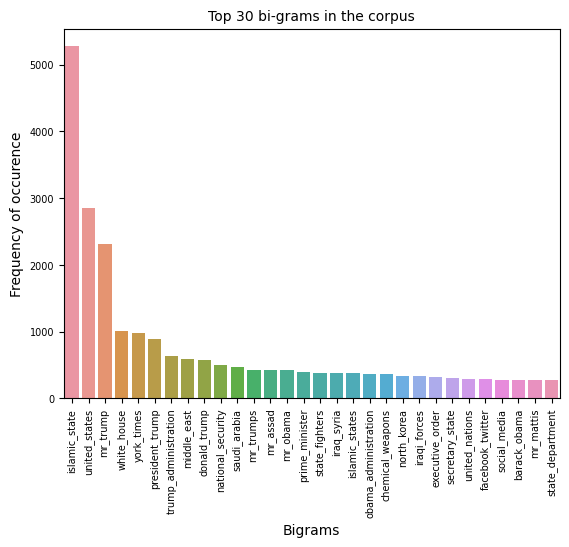

In [200]:
# Bar graph for most frequent bi-grams

# Appending the bigrams into one string

labels = [label[0] + '_' + label[1] for label in list(bigrams_30_dict.keys())]
values = list(bigrams_30_dict.values())

# Creating a dictionary of appended bigrams and frequency
bigram_dict = dict()
for i in range(len(labels)):
    bigram_dict[labels[i]] = values[i]

# Plotting the bigrams
sns.barplot(y = values, x = labels)
plt.title('Top 30 bi-grams in the corpus', fontsize=10)
plt.xlabel('Bigrams', fontsize=10)
plt.ylabel('Frequency of occurence', fontsize=10)
plt.xticks(rotation = 90, fontsize = 7)
plt.yticks(fontsize = 7)
plt.show()

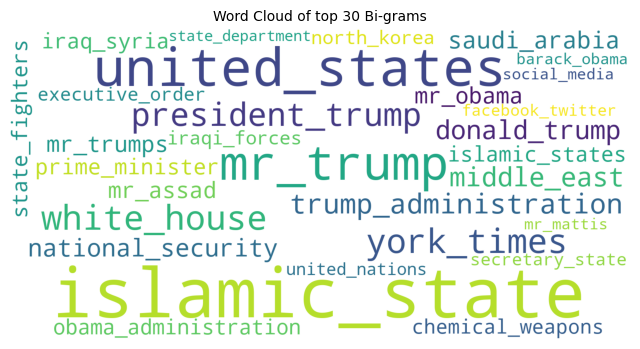

In [201]:
# Generating a word cloud for bigrams using the created bigram dictionary

wordcloud = WordCloud(width=1600, height=800, background_color='white').generate_from_frequencies(bigram_dict)

plt.figure(figsize=(8,8))
plt.title('Word Cloud of top 30 Bi-grams', fontsize=10)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [202]:
# Perform lemmatization on the tokens

'''
Only keeps the words with parts of speech as either of ('Noun', 'Adjective', 'Verb')
'''
spacy.cli.download("en_core_web_sm")
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB']):
    lemmatized_tokens = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        lemmatized_tokens.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return lemmatized_tokens

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [203]:
%%time
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, adv
tokens_lemmatized = lemmatization(all_tokens_without_stop, allowed_postags=['NOUN', 'ADJ'])

Wall time: 2min 4s


In [204]:
# Build the bigram and trigram models - higher threshold fewer phrases.
bigram = gensim.models.Phrases(tokens_lemmatized, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[tokens_lemmatized], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [205]:
# Functions to create n_grams
def make_bigrams(tokens_list):
    return [bigram_mod[article_tokens] for article_tokens in tokens_list]

def make_trigrams(tokens_list):
    return [trigram_mod[bigram_mod[article_tokens]] for article_tokens in tokens_list]

In [206]:
token_bigrams = make_bigrams(tokens_lemmatized)

In [207]:
token_bigrams[0]

['urkish',
 'official',
 'coup',
 'summer',
 'russian',
 'ambassador',
 'month',
 'gunman',
 'early',
 'year',
 'day',
 'news',
 'medium',
 'chief',
 'suspectne',
 'headline',
 'attack',
 'twitter',
 'turkish',
 'lawmaker',
 'nightclub',
 'period',
 'turkey',
 'cascade',
 'crisis',
 'syrian',
 'civil',
 'border',
 'event',
 'turkey',
 'close',
 'ally',
 'nation',
 'close',
 'russian',
 'secure',
 'ceasefire',
 'story',
 'routine',
 'travel',
 'warning',
 'american',
 'embassy',
 'responsibility',
 'stun',
 'gunman',
 'stock',
 'american',
 'assault',
 'division',
 'turkey',
 'secular',
 'religious',
 'bringing',
 'common',
 'fight',
 'terrorism',
 'attack',
 'gunman',
 'turkey',
 'shift',
 'west',
 'time',
 'democracy',
 'crackdown',
 'civil',
 'society',
 'reflection',
 'critic',
 'paranoia',
 'authoritarianism',
 'leadership',
 'country',
 'confront',
 'terrorism',
 'turkish',
 'society',
 'administration',
 'day',
 'enemy',
 'islamic',
 'state',
 'kurdish',
 'militant',
 'supporter'

In [208]:
type(token_bigrams)

list

In [209]:
%%time

# Mapping the tokens with those of the dictionary words

id2word = corpora.Dictionary(token_bigrams)

corpus = []
for token_list in token_bigrams:
    new = id2word.doc2bow(token_list)
    corpus.append(new)

Wall time: 1.85 s


In [210]:
type(corpus)

list

In [211]:
corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 3),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 2),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 2),
 (17, 1),
 (18, 8),
 (19, 1),
 (20, 1),
 (21, 2),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 1),
 (26, 1),
 (27, 1),
 (28, 1),
 (29, 1),
 (30, 1),
 (31, 1),
 (32, 1),
 (33, 1),
 (34, 1),
 (35, 1),
 (36, 1),
 (37, 1),
 (38, 3),
 (39, 1),
 (40, 1),
 (41, 1),
 (42, 2),
 (43, 1),
 (44, 1),
 (45, 1),
 (46, 1),
 (47, 1),
 (48, 1),
 (49, 7),
 (50, 4),
 (51, 3),
 (52, 3),
 (53, 1),
 (54, 1),
 (55, 1),
 (56, 1),
 (57, 5),
 (58, 2),
 (59, 1),
 (60, 1),
 (61, 3),
 (62, 1),
 (63, 1),
 (64, 4),
 (65, 1),
 (66, 1),
 (67, 1),
 (68, 1),
 (69, 1),
 (70, 1),
 (71, 2),
 (72, 1),
 (73, 2),
 (74, 1),
 (75, 1),
 (76, 1),
 (77, 1),
 (78, 1),
 (79, 1),
 (80, 1),
 (81, 1),
 (82, 1),
 (83, 1),
 (84, 1),
 (85, 1),
 (86, 1),
 (87, 2),
 (88, 1),
 (89, 1),
 (90, 1),
 (91, 4),
 (92, 1),
 (93, 4),
 (94, 1),
 (95, 1),
 (96, 1),
 (97, 1),
 (98, 2),
 (99, 2),
 (100, 1),

### Latent Dirichlet Allocation - Topic Model building

In [212]:
# Building the LDA model
'''
As a trail run, 8 topics are selected.

num_topics: No of topics required.
update_every: Number of documents to be iterated through for each update.
passes: Number of times algorithm passes through the corpus.
alpha: A-priori belief on document-topic distribution.

'''

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics = 8,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=20,
                                           alpha="auto")

### Visualizing the topics

In [213]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds="mmds", R=30)

import warnings
warnings.filterwarnings('ignore')

In [214]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.271971 -0.166186       1        1  23.426802
2      0.035080 -0.020324       2        1  22.896947
3     -0.199169 -0.227284       3        1  21.314049
5     -0.302557  0.025119       4        1  12.861267
4     -0.034344 -0.346172       5        1  10.639431
1      0.292256  0.109838       6        1   8.532918
7     -0.027891  0.336407       7        1   0.200660
6     -0.035345  0.288602       8        1   0.127926, topic_info=                Term         Freq        Total Category  logprob  loglift
425            iraqi  2194.000000  2194.000000  Default  30.0000  30.0000
415            force  3346.000000  3346.000000  Default  29.0000  29.0000
18            attack  3079.000000  3079.000000  Default  28.0000  28.0000
186            state  5959.000000  5959.000000  Default  27.0000  27.0000
99           islamic  4651.000000  4651.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
1797  fawnbrook_case     0.432505     1.299779   Topic8  -7.1783   5.5611
8653        kickback     0.431408     1.308752   Topic8  -7.1809   5.5517
6375            limp     0.427639     1.297612   Topic8  -7.1897   5.5515
1718         conceal     0.418431     1.286349   Topic8  -7.2114   5.5384
912     apprehension     0.403635     1.273168   Topic8  -7.2474   5.5127

[503 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
1156      1  0.046369        activity
1156      3  0.171208        activity
1156      4  0.221144        activity
1156      6  0.559993        activity
6         1  0.509910  administration
...     ...       ...             ...
232       6  0.029096            year
1138      2  0.804375           young
1138      4  0.192886           young
3225      6  0.986065         youtube
2538      5  0.978592             ypg

[833 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 6, 5, 2, 8, 7])

### Analyzing the topics

In [215]:
# Print the Keywords with the repsective weightage in the 10 topics

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


[(0,
  '0.018*"trump" + 0.012*"president" + 0.009*"year" + 0.009*"week" + '
  '0.007*"administration" + 0.007*"policy" + 0.007*"time" + 0.007*"question" + '
  '0.007*"big" + 0.007*"country"'),
 (1,
  '0.018*"company" + 0.016*"official" + 0.011*"information" + '
  '0.011*"terrorist" + 0.010*"intelligence" + 0.010*"country" + '
  '0.009*"technology" + 0.008*"government" + 0.008*"order" + 0.008*"report"'),
 (2,
  '0.011*"year" + 0.008*"time" + 0.007*"woman" + 0.007*"family" + '
  '0.007*"child" + 0.007*"day" + 0.007*"story" + 0.007*"life" + 0.005*"isis" + '
  '0.005*"school"'),
 (3,
  '0.030*"state" + 0.023*"syrian" + 0.021*"islamic" + 0.021*"group" + '
  '0.017*"official" + 0.016*"military" + 0.015*"government" + 0.015*"force" + '
  '0.011*"isis" + 0.009*"regime"'),
 (4,
  '0.046*"iraqi" + 0.040*"force" + 0.037*"state" + 0.034*"islamic" + '
  '0.025*"military" + 0.023*"city" + 0.021*"troop" + 0.017*"fighter" + '
  '0.015*"militant" + 0.013*"official"'),
 (5,
  '0.040*"attack" + 0.022*"po

'\n(0,\n  \'0.034*"state" + 0.029*"islamic" + 0.024*"force" + 0.019*"military" + \'\n  \'0.016*"group" + 0.014*"fighter" + 0.014*"official" + 0.014*"syrian" + \'\n  \'0.014*"government" + 0.013*"iraqi"\')\n\nHow to read?\n\nIn topic 0, the word "state" is the most imp with a weightage of 0.034 \n   topic 0, the word "islamic" is the second most imp with a weightage of 0.029 ... \n\n'

### Model Evaluation

In [216]:
# Compute Perplexity -- a measure of how good the model is. Lower the value better the model.
print('Perplexity: ', lda_model.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model = lda_model, texts = token_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', np.round(coherence_lda, 3)) 

Perplexity:  -8.10793210102702
Coherence Score:  0.502


### Choosing the optimal number of topics

In [217]:
%%time
Coherence_scores = []
Perplexity_scores = []

for count in range(5, 15):

    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics = count,
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha="auto")
    # Compute Perplexity
    Perplexity_scores.append(lda_model.log_perplexity(corpus))
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model = lda_model, texts = token_bigrams, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    Coherence_scores.append(coherence_lda)

Wall time: 7min 42s


### Plotting the topic count Vs Coherence Score

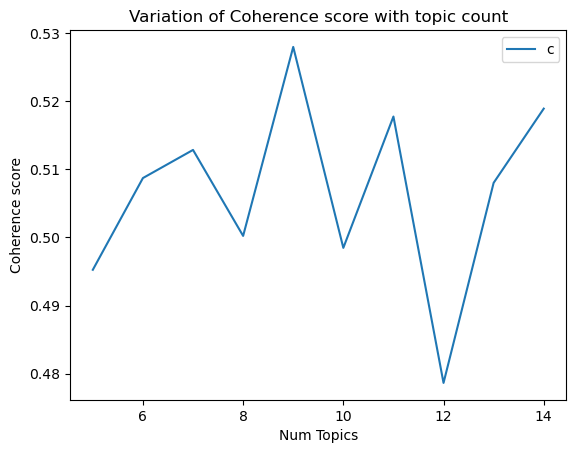

In [218]:
# The number of topics are chosen based on the higest Coherence Score.
# In our case, it is 12.

limit=15; start=5; step=1;
x = range(start, limit, step)
plt.plot(x, Coherence_scores)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title("Variation of Coherence score with topic count")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [219]:
Coherence_scores

[0.49525635658917083,
 0.5087195644503106,
 0.5128469897604623,
 0.5002297252632881,
 0.5279626029327924,
 0.4984751360661218,
 0.5177445337653668,
 0.478654458763964,
 0.5080151132105908,
 0.518906993229469]

In [220]:
# Since we are starting from the 5 topics, we have to offset max index with 5.

optimal_no_models = np.argmax(Coherence_scores) + 5

In [221]:
optimal_no_models

9

### Building the model with optimal number of topics

In [222]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics= optimal_no_models,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds="mmds", R=30)

import warnings
warnings.filterwarnings('ignore')

### Visualizing the topics and word distributions

In [223]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.134048  0.308475       1        1  25.280934
2      0.304271  0.149788       2        1  17.271776
1     -0.293212  0.077215       3        1  16.633237
3     -0.065515  0.064532       4        1  14.867354
5      0.099311  0.274099       5        1  14.179141
8     -0.121449 -0.286945       6        1   6.418304
4     -0.306006 -0.158007       7        1   4.154578
7      0.330287 -0.195388       8        1   1.056800
6      0.186360 -0.233769       9        1   0.137875, topic_info=         Term         Freq        Total Category  logprob  loglift
99    islamic  4744.000000  4744.000000  Default  30.0000  30.0000
186     state  6169.000000  6169.000000  Default  29.0000  29.0000
415     force  3339.000000  3339.000000  Default  28.0000  28.0000
425     iraqi  2066.000000  2066.000000  Default  27.0000  27.0000
18     attack  3007.000000  3007.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
1647    aloud     0.455303     1.411946   Topic9  -7.2019   5.4548
2071  unleash     0.491602     1.544828   Topic9  -7.1252   5.4416
1683    boise     0.442847     1.398145   Topic9  -7.2296   5.4369
1781  espouse     0.429691     1.391981   Topic9  -7.2598   5.4112
1974    pupil     0.429691     1.391981   Topic9  -7.2598   5.4112

[594 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
10335      2  0.990969     acquisition
559        3  0.979622         acronym
2539       1  0.175153              ad
2539       8  0.810084              ad
6          1  0.376335  administration
...      ...       ...             ...
1138       4  0.030839           young
1138       5  0.127468           young
3225       5  0.117226         youtube
3225       8  0.859657         youtube
2538       7  0.967855             ypg

[1054 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4, 6, 9, 5, 8, 7])